In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import shutil
import cv2 as cv

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, save_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

In [2]:
data = r'/kaggle/input/cauli12/Original Dataset/'
type_disea = os.listdir(data)
print(type_disea)
for i in type_disea:
  os.makedirs(os.path.join(r'/kaggle/working/dataset_split/test', i), exist_ok=True)
  os.makedirs(os.path.join(r'/kaggle/working/dataset_split/train', i), exist_ok=True)

def split_data_files(X, Y):
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,random_state=42)
  for i in range(len(X_train)): shutil.copy(os.path.join(os.path.join(data, y_train[i]),X_train[i]), os.path.join('/kaggle/working/dataset_split/train', y_train[i]))
  for i in range(len(X_test)) : shutil.copy(os.path.join(os.path.join(data, y_test[i]),X_test[i]), os.path.join('/kaggle/working/dataset_split/test', y_test[i]))
  
for folder in type_disea:
  X,Y = [],[]
  curr_path = os.path.join(data, folder)
  for filename in os.listdir(curr_path):
    X.append(filename)
    Y.append(folder)
  split_data_files(X, Y)

['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']


In [3]:
data = '/kaggle/working/dataset_split'

In [4]:
def create_df(TYPE):
  filepaths, labels = [],[]
  data_path = os.path.join(data, TYPE)
  for folder in os.listdir(data_path):
    cf = os.path.join(data_path, folder)
    for filename in os.listdir(cf):
      filepaths.append(os.path.join(cf, filename))
      labels.append(folder)

  fp = pd.Series(filepaths, name='filepaths')
  lb = pd.Series(labels, name='labels')
  df = pd.concat([fp, lb], axis=1)
  del filepaths, labels
  return df

train_df = create_df('train').sample(frac=1, random_state=42)
test_df = create_df('test').sample(frac=1, random_state=42)

In [5]:
batch_size=20
img_size = (224, 224)
test  = ImageDataGenerator().flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False)

Found 133 validated image filenames belonging to 4 classes.


In [6]:
img_shape = (img_size[0], img_size[1], 3)
def get_model():
  base_model = tf.keras.applications.efficientnet.EfficientNetB1(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
  base_model.trainable = True
  x = base_model.output
  x = BatchNormalization()(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.3)(x)
  outputs = Dense(4, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=outputs)
  lr=.001
  model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [7]:
def make_balance_train(df, num_fol):
  generate_more_data(df, num_fol)
  aug_df = create_df_more(num_fol)
  new_df = pd.concat([df, aug_df], ignore_index=True)
  return new_df
# make_balance_train(train_df.loc[train_idx])

In [8]:
def min_len_arr(df):
  minlenarr = []
  for i in type_disea:
    minlenarr.append(len(df.loc[df['labels']==i]))
  return minlenarr
# print(min_len_arr(train_df.loc[train_idx]))

def generate_more_data(df, num_fol):
    gene = ImageDataGenerator(brightness_range=[0.2,2.0],vertical_flip=True,shear_range=20)
    len_disea = min_len_arr(df)
    print(len_disea)
    max_disea = max(len_disea)
#     print(max_disea)
    for i in type_disea:
        num_of_disea = len_disea[type_disea.index(i)]
        cur_path = os.path.join(f'/kaggle/working/more_img{num_fol}',i)
        create_img = gene.flow_from_dataframe(df.loc[df['labels']==i], x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=1, save_to_dir=cur_path, save_format='jpg')
        if i == type_disea[len_disea.index(max_disea)]: pass
        else:
            for j in range(0, max_disea-num_of_disea):
              hh = next(create_img)       
# generate_more_data(train_df.loc[train_idx],1)

def create_df_more(num_fol):
  filepaths, labels = [],[]
  data_path = f'/kaggle/working/more_img{num_fol}'
  for folder in os.listdir(data_path):
    cf = os.path.join(data_path, folder)
    for filename in os.listdir(cf):
      filepaths.append(os.path.join(cf, filename))
      labels.append(folder)

  fp = pd.Series(filepaths, name='filepaths')
  lb = pd.Series(labels, name='labels')
  df = pd.concat([fp, lb], axis=1)
  del filepaths, labels
#   print(df)
  return df

In [9]:
def create_fol(n):
  os.makedirs(f'/kaggle/working/more_img{n}', exist_ok=True)
  for i in type_disea:
    os.makedirs(os.path.join(f'/kaggle/working/more_img{n}', i), exist_ok=True)

In [10]:
print(type_disea)

['Downy Mildew', 'Black Rot', 'Bacterial spot rot', 'No disease']


[121, 59, 103, 135]
Found 121 validated image filenames belonging to 1 classes.
Found 59 validated image filenames belonging to 1 classes.
Found 103 validated image filenames belonging to 1 classes.
Found 135 validated image filenames belonging to 1 classes.
Found 540 validated image filenames belonging to 4 classes.
Found 105 validated image filenames belonging to 4 classes.
27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1726931411.280796      99 service.cc:145] XLA service 0x78525c003470 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726931411.280847      99 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1726931492.022455      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17/17 ━━━━━━━━━━━━━━━━━━━━ 253s 8s/step - accuracy: 0.5519 - loss: 1.2137 - val_accuracy: 0.5143 - val_loss: 2.3312
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9544 - loss: 0.1464 - val_accuracy: 0.7143 - val_loss: 1.2238
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9858 - loss: 0.0536 - val_accuracy: 0.8476 - val_loss: 0.6300
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9821 - loss: 0.0528 - val_accuracy: 0.9143 - val_loss: 0.3712
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9990 - loss: 0.0190 - val_accuracy: 0.9238 - val_loss: 0.2808
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9944 - loss: 0.0119 - val_accuracy: 0.9429 - val_loss: 0.2254
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9998 - loss: 0.0096 - val_accuracy: 0.9714 - val_loss: 0.1918
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9913 - loss: 0.0186 - val_accuracy: 0.9619 - val_loss: 0.1184
Ep

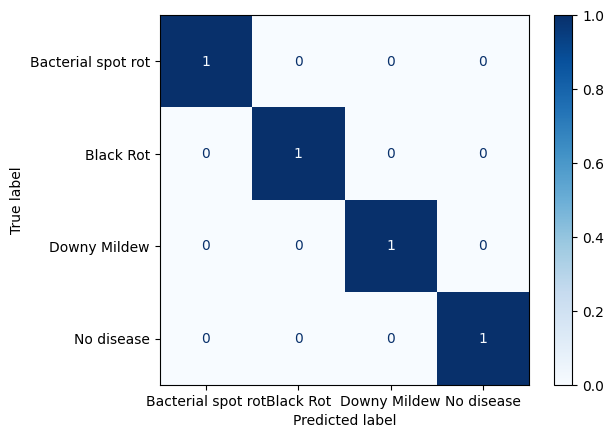

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      1.00      1.00        35
         Black Rot       1.00      1.00      1.00        20
      Downy Mildew       1.00      1.00      1.00        36
        No disease       1.00      1.00      1.00        42

          accuracy                           1.00       133
         macro avg       1.00      1.00      1.00       133
      weighted avg       1.00      1.00      1.00       133

[104, 62, 118, 134]
Found 104 validated image filenames belonging to 1 classes.
Found 62 validated image filenames belonging to 1 classes.
Found 118 validated image filenames belonging to 1 classes.
Found 134 validated image filenames belonging to 1 classes.
Found 536 validated image filenames belonging to 4 classes.
Found 105 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 226s 7s/step - accuracy: 0.5445 - loss: 1.2293 - val_accuracy: 0.3333 - val_loss: 2.6656
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9443 - loss: 0.1592 - val_accuracy: 0.6286 - val_loss: 0.9975
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9668 - loss: 0.0825 - val_accuracy: 0.8667 - val_loss: 0.4281
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9936 - loss: 0.0260 - val_accuracy: 0.8857 - val_loss: 0.3034
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9896 - loss: 0.0333 - val_accuracy: 0.9333 - val_loss: 0.1854
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9973 - loss: 0.0146 - val_accuracy: 0.9714 - val_loss: 0.1124
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9957 - loss: 0.0152 - val_accuracy: 0.9714 - val_loss: 0.0836
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9965 - loss: 0.0106 - val_accuracy: 0.9714 - val_loss: 0.0550
Ep

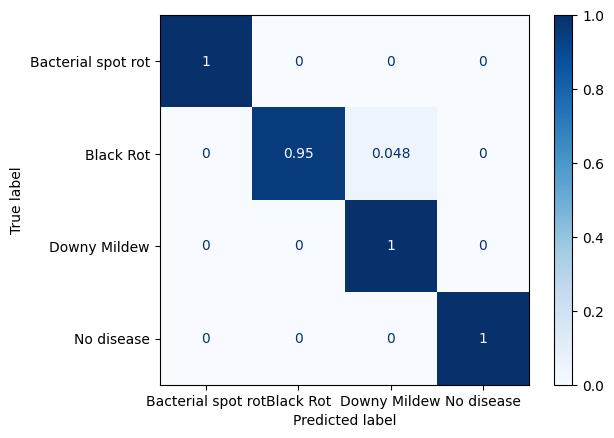

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      1.00      1.00        35
         Black Rot       1.00      0.95      0.98        21
      Downy Mildew       0.97      1.00      0.99        35
        No disease       1.00      1.00      1.00        42

          accuracy                           0.99       133
         macro avg       0.99      0.99      0.99       133
      weighted avg       0.99      0.99      0.99       133

[118, 65, 110, 125]
Found 118 validated image filenames belonging to 1 classes.
Found 65 validated image filenames belonging to 1 classes.
Found 110 validated image filenames belonging to 1 classes.
Found 125 validated image filenames belonging to 1 classes.
Found 500 validated image filenames belonging to 4 classes.
Found 105 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 229s 8s/step - accuracy: 0.4706 - loss: 1.3812 - val_accuracy: 0.6190 - val_loss: 1.5917
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9314 - loss: 0.2028 - val_accuracy: 0.7810 - val_loss: 0.7146
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9828 - loss: 0.0579 - val_accuracy: 0.8952 - val_loss: 0.3071
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9949 - loss: 0.0198 - val_accuracy: 0.9333 - val_loss: 0.1941
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9897 - loss: 0.0591 - val_accuracy: 0.9238 - val_loss: 0.2452
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9938 - loss: 0.0186 - val_accuracy: 0.9333 - val_loss: 0.2179
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9959 - loss: 0.0141 - val_accuracy: 0.9524 - val_loss: 0.1474
Epoch 8/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9979 - loss: 0.0077 - val_accuracy: 0.9619 - val_loss: 0.0960
Ep

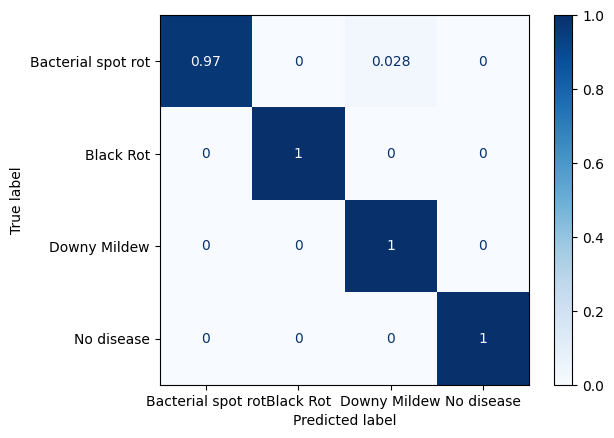

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      0.97      0.99        36
         Black Rot       1.00      1.00      1.00        20
      Downy Mildew       0.97      1.00      0.99        35
        No disease       1.00      1.00      1.00        42

          accuracy                           0.99       133
         macro avg       0.99      0.99      0.99       133
      weighted avg       0.99      0.99      0.99       133

[109, 70, 110, 130]
Found 109 validated image filenames belonging to 1 classes.
Found 70 validated image filenames belonging to 1 classes.
Found 110 validated image filenames belonging to 1 classes.
Found 130 validated image filenames belonging to 1 classes.
Found 520 validated image filenames belonging to 4 classes.
Found 104 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.5135 - loss: 1.3239

I0000 00:00:1726933851.520962     100 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_4', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_6', 40 bytes spill stores, 40 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_7', 36 bytes spill stores, 36 bytes spill loads



17/17 ━━━━━━━━━━━━━━━━━━━━ 223s 7s/step - accuracy: 0.5321 - loss: 1.2744 - val_accuracy: 0.7115 - val_loss: 0.7548
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9331 - loss: 0.2036 - val_accuracy: 0.8942 - val_loss: 0.3231
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9679 - loss: 0.0912 - val_accuracy: 0.9231 - val_loss: 0.1816
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9927 - loss: 0.0312 - val_accuracy: 0.9519 - val_loss: 0.1285
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9858 - loss: 0.0325 - val_accuracy: 0.9712 - val_loss: 0.1020
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9941 - loss: 0.0312 - val_accuracy: 0.9712 - val_loss: 0.1145
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9922 - loss: 0.0231 - val_accuracy: 0.9712 - val_loss: 0.1109
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9864 - loss: 0.0247 - val_accuracy: 0.9615 - val_loss: 0.1113
Ep

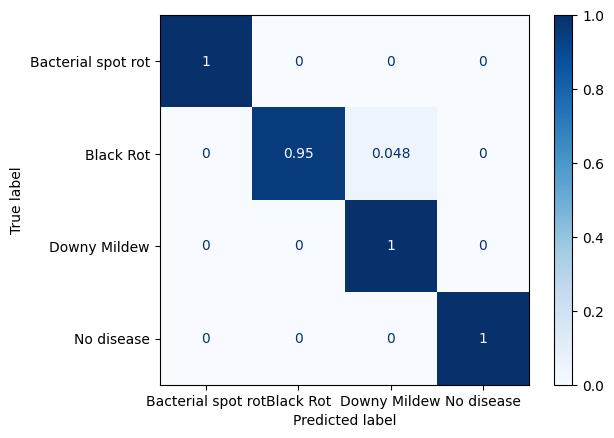

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      1.00      1.00        35
         Black Rot       1.00      0.95      0.98        21
      Downy Mildew       0.97      1.00      0.99        35
        No disease       1.00      1.00      1.00        42

          accuracy                           0.99       133
         macro avg       0.99      0.99      0.99       133
      weighted avg       0.99      0.99      0.99       133

[112, 64, 111, 132]
Found 112 validated image filenames belonging to 1 classes.
Found 64 validated image filenames belonging to 1 classes.
Found 111 validated image filenames belonging to 1 classes.
Found 132 validated image filenames belonging to 1 classes.
Found 528 validated image filenames belonging to 4 classes.
Found 104 validated image filenames belonging to 4 classes.
Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 225s 7s/step - accuracy: 0.5030 - loss: 1.2597 - val_accuracy: 0.4904 - val_loss: 2.4572
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9253 - loss: 0.2416 - val_accuracy: 0.7212 - val_loss: 1.0689
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.9583 - loss: 0.1075 - val_accuracy: 0.8750 - val_loss: 0.4650
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9814 - loss: 0.0788 - val_accuracy: 0.9327 - val_loss: 0.2016
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9920 - loss: 0.0173 - val_accuracy: 0.9615 - val_loss: 0.1058
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9939 - loss: 0.0229 - val_accuracy: 0.9712 - val_loss: 0.0975
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9957 - loss: 0.0155 - val_accuracy: 0.9135 - val_loss: 0.2601
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9928 - loss: 0.0203 - val_accuracy: 0.9615 - val_loss: 0.0660
Ep

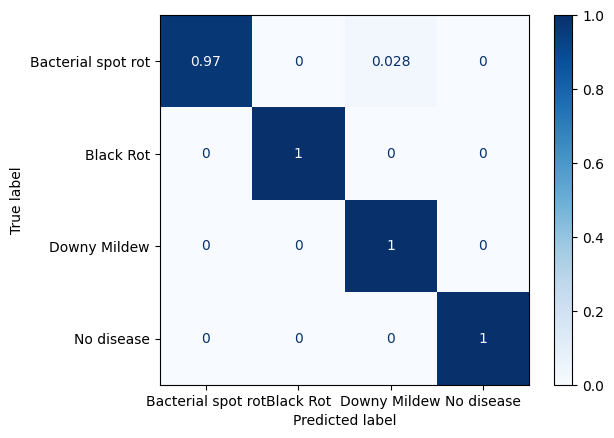

                    precision    recall  f1-score   support

Bacterial spot rot       1.00      0.97      0.99        36
         Black Rot       1.00      1.00      1.00        20
      Downy Mildew       0.97      1.00      0.99        35
        No disease       1.00      1.00      1.00        42

          accuracy                           0.99       133
         macro avg       0.99      0.99      0.99       133
      weighted avg       0.99      0.99      0.99       133



In [11]:
k = StratifiedKFold(n_splits=5,shuffle=True)
k.get_n_splits(train_df['filepaths'], train_df['labels'])

epochs = 15
gen = ImageDataGenerator(horizontal_flip=True, rotation_range=30, width_shift_range=.2, height_shift_range=.2, zoom_range=.2)
for i, (train_idx, valid_idx) in enumerate(k.split(train_df['filepaths'], train_df['labels'])):
  create_fol(i) 
  a = make_balance_train(train_df.loc[train_idx], i)
  b = train_df.loc[valid_idx]
  train = ImageDataGenerator().flow_from_dataframe(a, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=32)
  valid = ImageDataGenerator().flow_from_dataframe(b, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True)  
  
  model = get_model()
  history = model.fit(x=train, epochs=epochs, validation_data=valid, validation_steps=None, shuffle=False, initial_epoch=0)
  history_dict = history.history
  class_indices = list(train.class_indices.values())
  class_names = list(train.class_indices.keys())
  preds = model.predict(test)
  label = test.labels
  list_pred = []
  errors = 0
  for i, p in enumerate(preds):
    index = np.argmax(p)
    list_pred.append(index)
    if class_indices[index] != label[i]:
      errors+=1
  acc = (1.0 - errors/len(preds)) * 100
  print('Errors = ', errors, "Acc = ", acc)
  cm = confusion_matrix(list_pred, label, normalize='true')
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()
  report = classification_report(list_pred, label,target_names=class_names)
  print(report)